In [1]:
import pandas as pd
import cv2
import numpy as np
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization , Activation, MaxPool2D, UpSampling2D, Concatenate, MaxPooling2D, Dropout, Conv2DTranspose, concatenate
from tensorflow.keras.models import Model
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
import matplotlib.pyplot as plt
import os

In [2]:
Height = 128
Width= 128
input_shape = (128,128,3)
NumOfCategories = 3

# U-NET

In [3]:
def double_conv_block(x, n_filters):

    # Conv2D then ReLU activation
    x = Conv2D(n_filters, 3, padding = "same", activation = "relu")(x)
    # Conv2D then ReLU activation
    x = Conv2D(n_filters, 3, padding = "same", activation = "relu")(x)

    return x

def downsample_block(x, n_filters):
    f = double_conv_block(x, n_filters)
    p = MaxPool2D(2)(f)
    p = Dropout(0.3)(p)

    return f, p

def upsample_block(x, conv_features, n_filters):
    # upsample
    x = Conv2DTranspose(n_filters, 3, 2, padding="same")(x)
    # concatenate 
    x = concatenate([x, conv_features])
    # dropout
    x = Dropout(0.3)(x)
    # Conv2D twice with ReLU activation
    x = double_conv_block(x, n_filters)

    return x

def build_unet_model():

    # inputs
    inputs = Input(shape=(128,128,3))

    # encoder: contracting path - downsample
    # 1 - downsample
    f1, p1 = downsample_block(inputs, 64)
    # 2 - downsample
    f2, p2 = downsample_block(p1, 128)
    # 3 - downsample
    f3, p3 = downsample_block(p2, 256)
    # 4 - downsample
    f4, p4 = downsample_block(p3, 512)

    # 5 - bottleneck
    bottleneck = double_conv_block(p4, 1024)

    # decoder: expanding path - upsample
    # 6 - upsample
    u6 = upsample_block(bottleneck, f4, 512)
    # 7 - upsample
    u7 = upsample_block(u6, f3, 256)
    # 8 - upsample
    u8 = upsample_block(u7, f2, 128)
    # 9 - upsample
    u9 = upsample_block(u8, f1, 64)

    # outputs
    outputs = Conv2D(3, 1, padding="same", activation = "softmax")(u9)

    # unet model with Keras Functional API
    unet_model = tf.keras.Model(inputs, outputs, name="U-Net")

    return unet_model

In [4]:

def conv_block(inputs, filters, pool=True):
    x = Conv2D(filters , 3 , padding="same")(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x= Conv2D(filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x= Activation("relu")(x)

    if pool == True:
        p = MaxPool2D((2,2))(x)
        return x, p
    else :
        return x


def build_unet(shape , num_classes):
    inputs = Input(shape)

    # Encoder
    x1 , p1 = conv_block(inputs, 16, pool=True)
    x2 , p2 = conv_block(p1, 32, pool=True)
    x3 , p3 = conv_block(p2 , 48 , pool=True)
    x4 , p4 = conv_block(p3, 64, pool=True)

    #Bridge
    b1 = conv_block(p4 , 128 , pool=False)

    # decoder
    u1 = UpSampling2D((2,2), interpolation="bilinear")(b1)
    c1 = Concatenate()([u1, x4])
    x5 = conv_block(c1, 64, pool=False)


    u2 = UpSampling2D((2,2),interpolation="bilinear")(x5)
    c2 = Concatenate()([u2, x3])
    x6 = conv_block(c2,48,pool=False)


    u3 = UpSampling2D((2,2),interpolation="bilinear")(x6)
    c3 = Concatenate()([u3, x2])
    x7 = conv_block(c3, 32 , pool=False)

    u4 = UpSampling2D((2,2) ,interpolation="bilinear")(x7)
    c4 = Concatenate()([u4, x1])
    x8 = conv_block(c4 , 16 , pool=False)


    # output layer
    output = Conv2D(num_classes,1, padding="same", activation="softmax")(x8)

    return Model(inputs, output)

# Train

In [5]:
allImagesNP  = np.load("./numpy_array/allImagesNP.npy")
maskImagesNP = np.load("./numpy_array/maskImagesNP.npy")

In [6]:
maskImagesNP = maskImagesNP -1 
maskForTheModel = tf.keras.utils.to_categorical(maskImagesNP , num_classes=NumOfCategories) # One hot encoder

maskForTheModel = maskForTheModel.astype(int) # convert from float to integer

In [7]:
X_train, X_val , y_train , y_val = train_test_split(allImagesNP, maskForTheModel, test_size=0.1 , random_state=42)

In [8]:
# Shapes
print(X_train.shape)
print(y_train.shape)

print(X_val.shape)
print(y_val.shape)

(3312, 128, 128, 3)
(3312, 128, 128, 3)
(368, 128, 128, 3)
(368, 128, 128, 3)


In [9]:
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

shape = (128,128,3)
num_classes = 3
lr = 1e-4 # 0.0001
batch_size = 4
epochs = 10

model = build_unet(shape , num_classes)

model.compile(loss="categorical_crossentropy", optimizer = tf.keras.optimizers.Adam(lr), metrics=['accuracy'])

stepsPerEpoch = np.ceil(len(X_train)/batch_size)
validationSteps = np.ceil(len(X_val)/batch_size)

best_model_file="./models/model-Unet.h5"

callbacks = [
    ModelCheckpoint(best_model_file, verbose=1, save_best_only=True),
    ReduceLROnPlateau(monitor="val_loss", patience=3, factor=0.1, verbose=1, min_lr=1e-6),
    EarlyStopping(monitor='val_loss',patience=5 , verbose=1)
]

history = model.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data = (X_val, y_val),
                    validation_steps = validationSteps,
                    steps_per_epoch = stepsPerEpoch,
                    shuffle=True,
                    callbacks=callbacks)

Epoch 1/10
828/828 [==============================] - ETA: 0s - loss: 0.7460 - accuracy: 0.7001
Epoch 1: val_loss improved from inf to 0.61280, saving model to ./models\model-Unet.h5


C:\Users\Taha\anaconda3\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


828/828 [==============================] - 265s 308ms/step - loss: 0.7460 - accuracy: 0.7001 - val_loss: 0.6128 - val_accuracy: 0.7705 - lr: 1.0000e-04
Epoch 2/10
828/828 [==============================] - ETA: 0s - loss: 0.5625 - accuracy: 0.7830
Epoch 2: val_loss improved from 0.61280 to 0.51405, saving model to ./models\model-Unet.h5
828/828 [==============================] - 317s 383ms/step - loss: 0.5625 - accuracy: 0.7830 - val_loss: 0.5140 - val_accuracy: 0.8012 - lr: 1.0000e-04
Epoch 3/10
828/828 [==============================] - ETA: 0s - loss: 0.5045 - accuracy: 0.8041
Epoch 3: val_loss improved from 0.51405 to 0.48865, saving model to ./models\model-Unet.h5
828/828 [==============================] - 301s 364ms/step - loss: 0.5045 - accuracy: 0.8041 - val_loss: 0.4886 - val_accuracy: 0.8071 - lr: 1.0000e-04
Epoch 4/10
828/828 [==============================] - ETA: 0s - loss: 0.4667 - accuracy: 0.8195
Epoch 4: val_loss improved from 0.48865 to 0.46017, saving model to ./mode

In [10]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

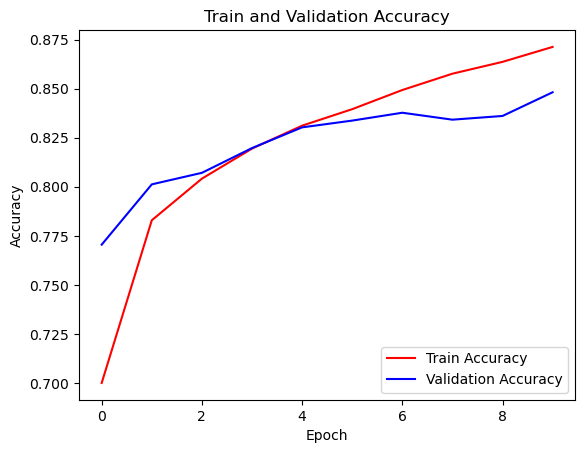

In [11]:
# train and validation Accuracy chart
plt.plot(epochs, acc , 'r', label="Train Accuracy")
plt.plot(epochs, val_acc, 'b' , label="Validation Accuracy")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title("Train and Validation Accuracy")
plt.legend(loc='lower right')
plt.show()

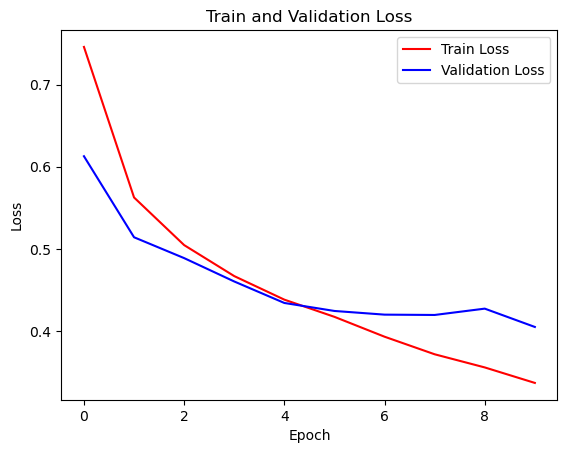

In [12]:
# train and validation loss chart
plt.plot(epochs, loss , 'r', label="Train Loss")
plt.plot(epochs, val_loss, 'b' , label="Validation Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title("Train and Validation Loss")
plt.legend(loc='upper right')
plt.show()